# Food Delivery: Visuals
Tsyr Rau Chen, Arailym Duisengali, Sheikh Noohery, Lo Ying Wu, and Kuan Rong Yang

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
conn = sqlite3.connect("/content/food_delivery.db")

In [ ]:
df_hour = pd.read_sql_query(
    """
    WITH hourly AS (
        SELECT
            STRFTIME('%H', order_datetime) AS hour,
            COUNT(*) AS total_orders,
            SUM(CASE WHEN status = 'canceled' THEN 1 ELSE 0 END) AS cancel_count
        FROM orders
        GROUP BY hour
    )
    SELECT
        hour,
        total_orders,
        cancel_count,
        ROUND( (cancel_count * 1.0 / total_orders) * 100, 2 ) AS cancel_rate_percent
    FROM hourly
    ORDER BY hour;
    """,
    conn)
df_hour


,hour,total_orders,cancel_count,cancel_rate_percent
0,11,263,32,12.17
1,12,282,30,10.64
2,13,240,27,11.25
3,14,264,29,10.98
4,15,250,22,8.80
5,16,275,27,9.82
6,17,1376,124,9.01
7,18,1355,151,11.14
8,19,1331,147,11.04
9,20,1307,131,10.02


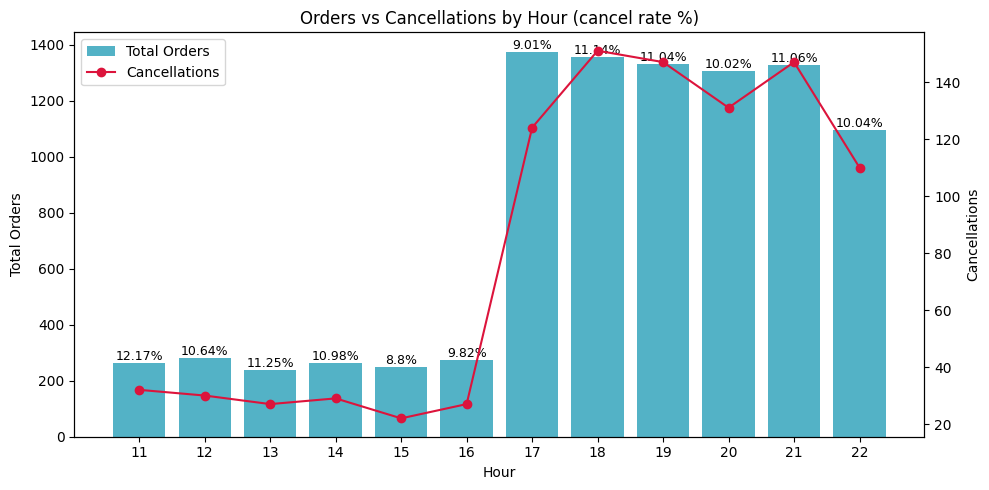

In [ ]:
#Q: Which hours show the highest operational strain based on cancellation rates? (Araikinn)

plt.figure(figsize=(10,5))
# hex colors
bar_color = "#1a99b4"
line_color = "#dc143c"
ax1 = plt.gca()

# total orders
bars = ax1.bar(df_hour["hour"], df_hour["total_orders"], color=bar_color, alpha=0.75)

# cancellations
ax2 = ax1.twinx()
line = ax2.plot(df_hour["hour"], df_hour["cancel_count"], color=line_color, marker="o")

# percentage
for i, bar in enumerate(bars):
    ax1.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        f'{df_hour.loc[i, "cancel_rate_percent"]}%',
        ha='center', va='bottom', fontsize=9)

ax1.set_title("Orders vs Cancellations by Hour (cancel rate %)")
ax1.set_xlabel("Hour")
ax1.set_ylabel("Total Orders")
ax2.set_ylabel("Cancellations")

# legend
ax1.legend(
    [bars, line[0]],
    ["Total Orders", "Cancellations"],
    loc="upper left"
)

plt.tight_layout()
plt.show()


The plot shows how total orders and cancellations vary by hour, along with the cancellation rate. Order volume is relatively low between 11:00 and 16:00, and the cancellation rate during this period stays around 8–12%. Starting at 17:00, total orders increase sharply, reaching their peak between 18:00 and 21:00. Cancellations also rise during these peak hours, but the cancellation rate remains fairly stable around 10–11%, indicating that the higher volume does not disproportionately increase cancellations. After 21:00, both orders and cancellations begin to decline, and the cancellation rate slightly drops as well. Overall, the plot highlights a strong evening peak in demand with consistently moderate cancellation rates throughout the day.

In [ ]:
df_tip = pd.read_sql_query(
    """
    WITH order_values AS (
        SELECT
            o.order_id,
            SUM(oi.quantity * oi.item_price_at_order) AS order_amount
        FROM orders o
        JOIN order_items oi ON o.order_id = oi.order_id
        WHERE o.status = 'delivered'
        GROUP BY o.order_id
    ),
    order_tips AS (
        SELECT
            d.order_id,
            d.tip_amount
        FROM deliveries d
    )
    SELECT
        CASE
            WHEN ov.order_amount < 20 THEN 'Under 20'
            WHEN ov.order_amount < 40 THEN '20–39.99'
            WHEN ov.order_amount < 60 THEN '40–59.99'
            ELSE '60+'
        END AS order_amount_band,
        AVG( (ot.tip_amount / ov.order_amount) * 100.0 ) AS avg_tip_percent
    FROM order_values ov
    JOIN order_tips ot ON ov.order_id = ot.order_id
    GROUP BY order_amount_band
    ORDER BY order_amount_band;
    """,
    conn
)

df_tip


,order_amount_band,avg_tip_percent
0,20–39.99,12.753583
1,40–59.99,12.336998
2,60+,12.658185
3,Under 20,12.942165


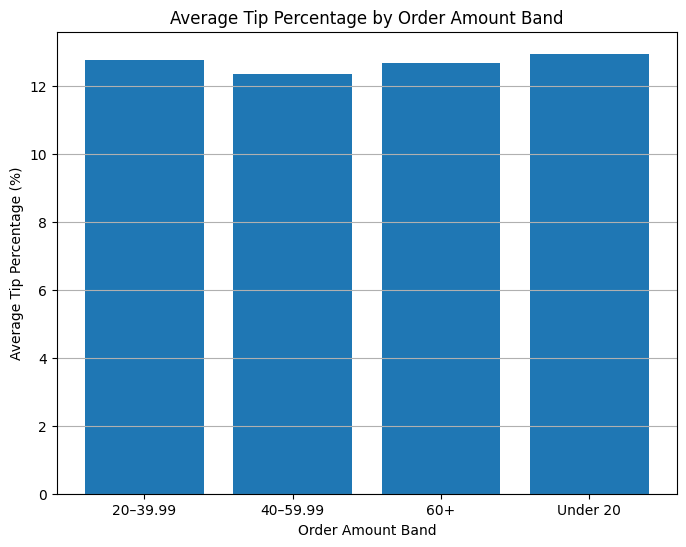

In [ ]:
#Q5: How does tip percentage vary across different order amounts? (mecole)


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(df_tip["order_amount_band"], df_tip["avg_tip_percent"])
plt.xlabel("Order Amount Band")
plt.ylabel("Average Tip Percentage (%)")
plt.title("Average Tip Percentage by Order Amount Band")
plt.grid(True, axis="y")
plt.show()


Interpret:The chart shows that the average tip percentage is fairly consistent across all order amount bands. Customers tend to tip around 12–13% regardless of whether their order total is under \$20, between \$20–39.99, \$40–59.99, or above \$60. This suggests that tip behavior does not strongly depend on how much the customer spends. Even higher-value orders do not lead to significantly higher or lower tip percentages, indicating that customers typically follow a standard tipping habit rather than adjusting the tip based on the order amount.

In [ ]:
# SQL: frequency and recency per customer
df_cust = pd.read_sql_query(
"""
SELECT
    customer_id,
    COUNT(*) AS num_orders,
    -- days since last order for this customer
    CAST(
        JULIANDAY( (SELECT MAX(order_datetime) FROM orders) )
        - JULIANDAY( MAX(order_datetime) )
        AS INTEGER
    ) AS recency_days
FROM orders
WHERE customer_id IS NOT NULL
GROUP BY customer_id
ORDER BY customer_id;
""", conn)

conn.close()

df_cust.head()


,customer_id,num_orders,recency_days
0,1,24,3
1,2,13,16
2,3,21,7
3,4,17,9
4,5,20,3


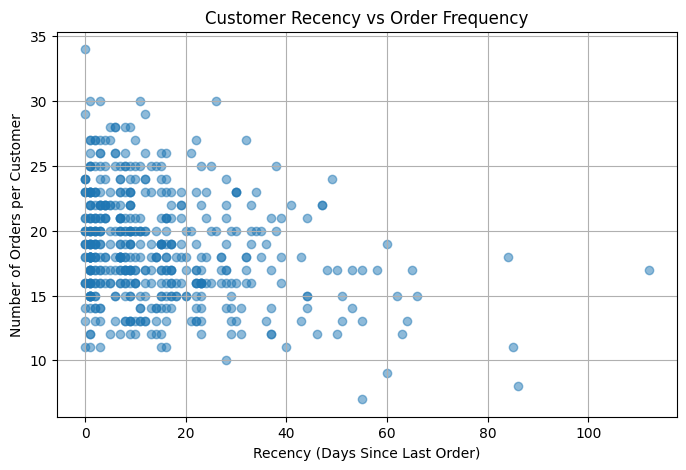

In [ ]:
plt.figure(figsize=(8, 5), facecolor="white")
plt.scatter(df_cust["recency_days"], df_cust["num_orders"], alpha=0.5)

plt.xlabel("Recency (Days Since Last Order)")
plt.ylabel("Number of Orders per Customer")
plt.title("Customer Recency vs Order Frequency")
plt.grid(True)
plt.show()


This scatter plot shows the relationship between how recently customers placed an order (recency) and how often they order overall (frequency). Most customers who order frequently tend to have low recency values, meaning they come back regularly and are highly engaged. As recency increases, the number of total orders generally decreases, indicating that customers who haven’t ordered in a long time tend to be lower-frequency or at risk of churning. Overall, the plot highlights a clear pattern: loyal customers order both often and recently, while inactive customers show higher recency and fewer total orders.